In [39]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Lab 7: Exploring latent features in convolutional neural networks

We saw in the Battleday, Peterson, & Griffiths paper a model that used convolutional neural networks to create high-dimensional representations of natural images. These representations could then be combined with more traditional models of cognition to explore how these models are able to handle real-world images.

In this lab, we'll be looking at how to get these representations out of convolutional neural networks. We'll learn:

1. How to download pre-trained neural networks with Keras.
2. How to extract features from these models.
3. How to perform linear discriminant analysis, a kind of *dimension reduction* technique that was used in the paper we read.

CNNs (convolutional neural networks) form representations of images at multiple levels. At the early levels of the network, the representations are collections of feature maps of small, local features like edges. At the levels right before the output, the features are global properties of the image. We're going to extract features at multiple levels from a pre-trained model and compare how these different representations capture category information through linear discriminant analysis.

## Part 1: Downloading a pre-trained model

When you train a model using Keras, you can save the model with `model.save()`. If you train a really useful model, a nice thing to do is to make the model available on the internet. Fortunately for us, there are nice people who have done this nice thing.

The Keras library has a set of pre-trained models that you can access through `tf.keras.applications`, and you can find [the documentation for this on the Keras website](https://keras.io/api/applications/).

We're going to use the VGG16 model in this lab. VGG was one of the early large-scale CNNs. It was developed by the Visual Geometry Group (VGG) and is 16 layers deep, hence VGG16. It is trained on the [ImageNet dataset](https://www.image-net.org/), which has 1,000 categories of images and millions of images. Training this model from scratch would take many days. Luckily, we can just download the model with the weights already in place.

Using the documentation on the website, figure out how to load the model. You can load it with the default parameters for this lab, but it might be worth reading up on the parameter options to understand what the options are. Then print the model summary and use the `tf.keras.utils.plot_model` command to visualize the model.

In [40]:
# load the model
vgg16_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [41]:
# summarize the model
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

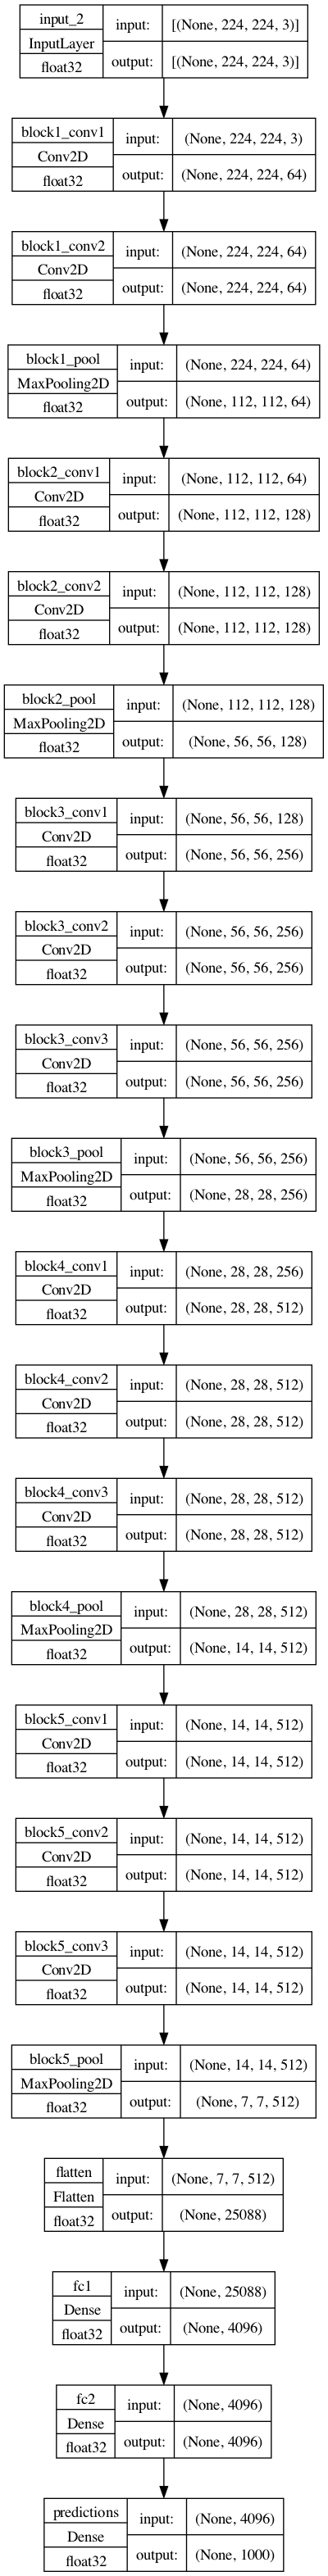

In [42]:
# plot the model
tf.keras.utils.plot_model(
    vgg16_model,
    to_file="vgg_16_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

When you print out the model, you'll see that it has a series of convolution layers, max pooling layers, and dense layers. You've seen convolution and dense layers before, but max pooling is new.

Max pooling layers are simply a way to shrink the size of the feature maps. They work by taking the **max** value in a local **pool**. Here's a handy picture I found on the internet.

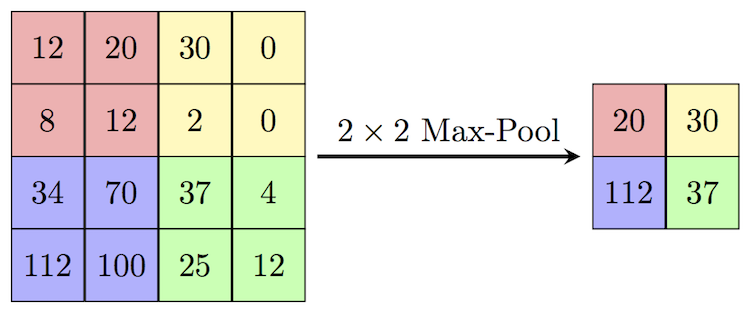

This image shows a 2x2 max pool operation. We take the feature map and select the maximum value in each 2x2 square. This shrinks the number of values by a factor of 4, since only one out of every 4 values is kept. You can think of it like resizing an image. Another way to achieve the same basic goal is to use a larger stride in the convolutional layer. More recent CNN architectures ususally do this instead of using max pooling.

Take a moment to study the summary of the model. Look at the shape output by each layer and try to understand why each layer is outputting the shape that it is. If you can follow the shapes, you probably have a grasp on how the convolution is working.

## Part 2: Get the data

Even though VGG16 was trained using ImageNet, we're going to work with CIFAR10, the same set of images that were used in the paper for this week.

The imagenet dataset is really big, and it's just easier to work with CIFAR10. For the goals of this lab, CIFAR will suffice. It's also an interesting test case for VGG16, because VGG16 wasn't trained on CIFAR images, which are much lower resolution and quality (32 x 32 pixels) than ImageNet (224 x 224 pixels).

CIFAR10 is included with Keras. You can get it the same way that we got MNIST and Fasion MNIST in previous labs. You can also lookup how to get it on the Keras website.

Get CIFAR10 and create the variables `x_train`, `y_train`, `x_test`, and `y_test`, following the conventions we've been using so far.

In [43]:
# load the CIFAR10 data and create the correct variables
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [44]:
y_train.shape

(50000, 1)

In [45]:
# 50000 images in train
# 10000 images in test
# size of CIFAR10 iamges: (32px, 32px, 3channels)
len(x_test)

10000

We can visualize one of the images using `pyplot.imshow()`

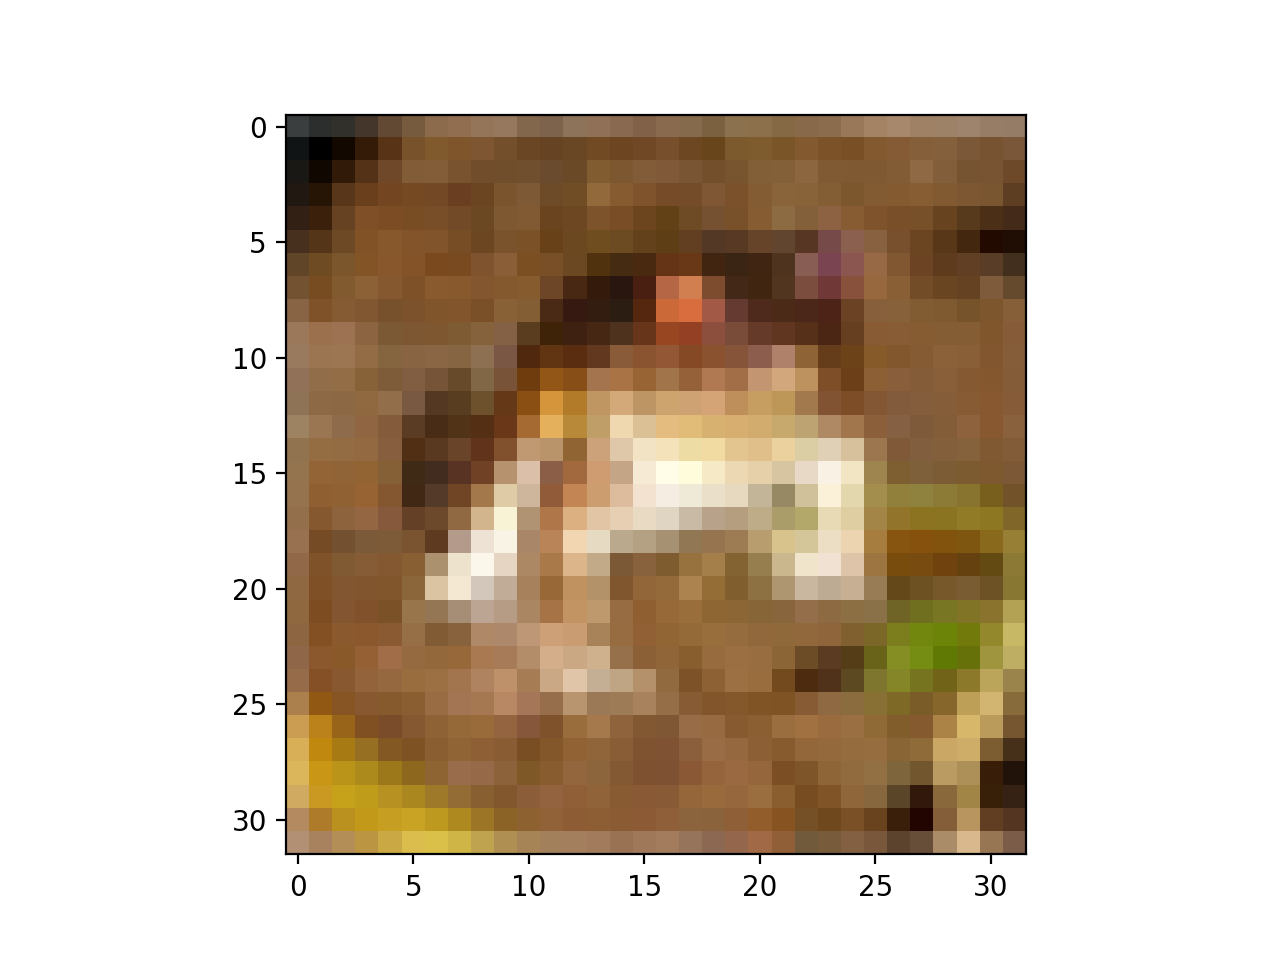

In [46]:
from matplotlib import pyplot
pyplot.imshow(x_train[0]) # try changing the value here to see other images

To use this data with VGG16, we need to get the images in the right format for the pre-trained model.

VGG16 is expecting inputs to be shape `(224, 224, 3)`, so the first thing we need to do is resize our data.

Let's do this using Keras's preprocessing layer, `tf.keras.layers.Resizing`.

Build a model with two layers. The first layer is an input layer with shape `(32, 32, 3)`, which is the size of the CIFAR10 images. The second layer is a resizing layer, that enlarges the image to `(224, 224, 3)`.

Since there are no weights for this model, you don't need to `compile()` it. Just create the model, and then use `.predict()` to process the `x_train` images.

**IMPORTANT**: Because we are on Colab using the free plan, we have somewhat limited memory resources. If you try to process the entire training data set like this you're session will probably crash from running out of memory. We can still get what we need for later by just using the first 1,000 examples. You can get the first 1,000 examples with `x_train[0:1000]`.

In [47]:
# create a model to resize the images
resize_input_layer = tf.keras.layers.Input((32, 32, 3), name="ResizeInput")
resize_resize_layer = tf.keras.layers.Resizing(224, 224)(resize_input_layer)

resize_model = tf.keras.Model(resize_input_layer, resize_resize_layer)

In [48]:
# generate resized data
x_train = x_train[0:1000]
x_train = resize_model.predict(x_train)
x_train.shape

32/32 [==============================] - 0s 13ms/step


(1000, 224, 224, 3)

Once you've resized the images there's still a couple more steps to get them in the same format as the images that were used to train VGG16. We need to swap the channels from RGB to BGR order and we need to convert pixel values from [0...255] to values that are centered around 0. Luckily, Keras provides a helpful function to do this preprocessing for us.

`tf.keras.applications.vgg16.preprocess_input()`

Use this function on your resized images. This will generate our final set of image data that we can feed to the network.

In [49]:
# generate the fully preprocessed data
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_train.shape

(1000, 224, 224, 3)

## Part 3: Get the model's predictions

Let's see how VGG16 handles these CIFAR10 images. Can it correctly categorize them?

Run the `.predict()` command on the input data you just finished creating, and save the return value in a variable called `predictions`.

In [50]:
predictions = vgg16_model.predict(x_train)

32/32 [==============================] - 87s 3s/step


Take a look at `predictions[0]`. It is an array of 1,000 numbers. These numbers sum to 1, and represent the probability that the image is each of the 1,000 categories that is in the ImageNet dataset.

In [51]:
len(predictions[0])

1000

Making sense of this array is difficult, but Keras again provides some useful code to help us out. If we run `tf.keras.applications.vgg16.decode_predictions()` we will get the labels and probabilities of the top 5 predictions that the model made. Run this command on all the `predictions`, saving it as `labels`.

In [52]:
labels = tf.keras.applications.vgg16.decode_predictions(predictions)

Take a look at `labels[0]`. What did the model think?

In [53]:
labels[0]

[('n01744401', 'rock_python', 0.056780487),
 ('n07584110', 'consomme', 0.052692886),
 ('n02112706', 'Brabancon_griffon', 0.03618118),
 ('n01773549', 'barn_spider', 0.032849632),
 ('n07590611', 'hot_pot', 0.030517876)]

Use `pyplot.imshow()` and `labels[]` to explore the behavior of the model a bit. Is it making somewhat reasonable decisions? Remember that VGG16 wasn't trained on images that are as low resolution as the ones we are feeding it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('n03796401', 'moving_van', 0.6283785), ('n04467665', 'trailer_truck', 0.14602208), ('n02690373', 'airliner', 0.036050085), ('n03770679', 'minivan', 0.020272624), ('n04285008', 'sports_car', 0.013198582)]


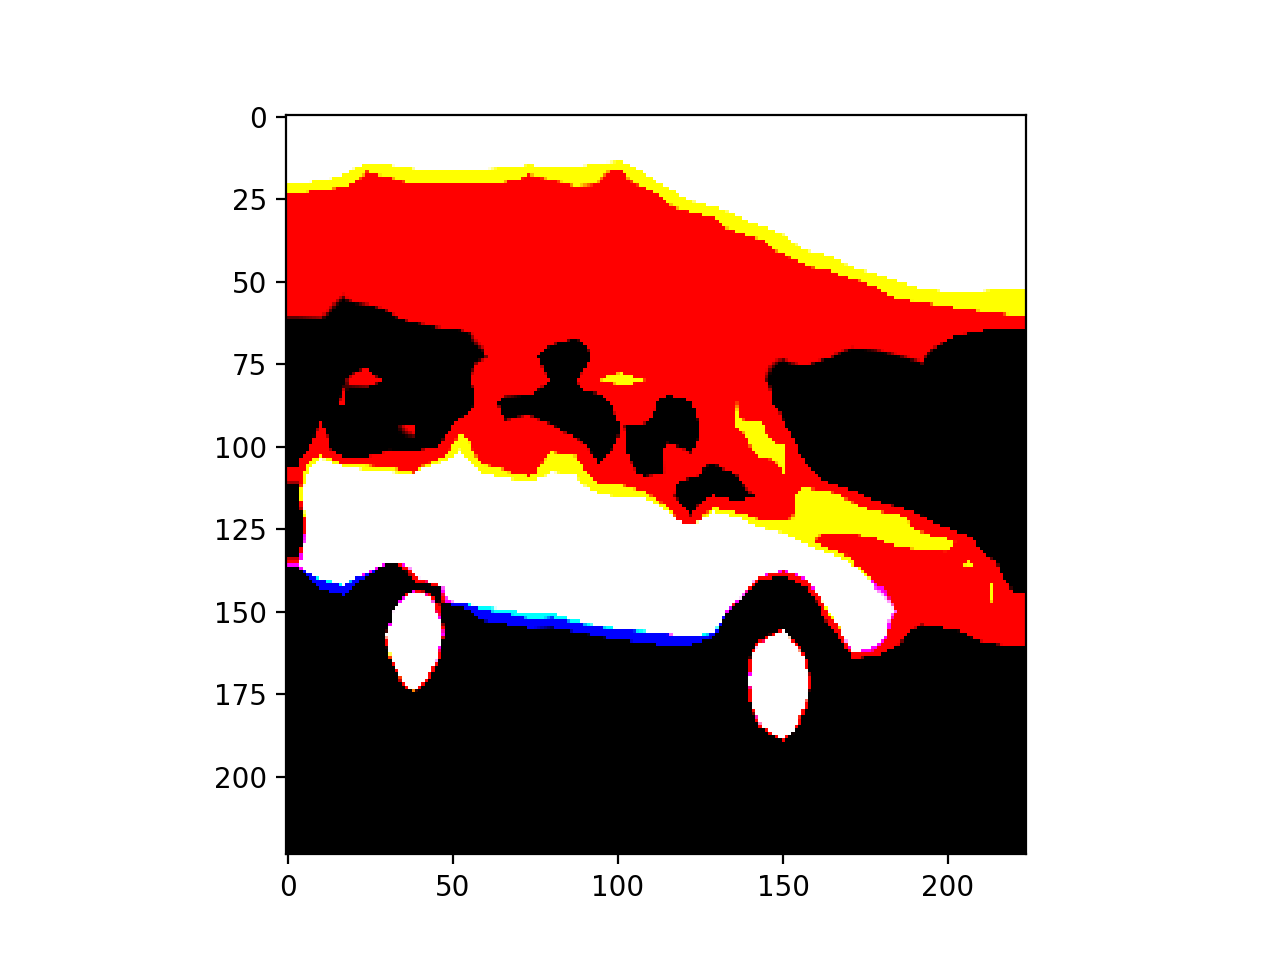

In [54]:
from matplotlib import pyplot

pyplot.imshow(x_train[4])
print(labels[4])

## Part 4: Linear Discriminant Analysis

LDA (linear discriminany analysis) is a technique for dimension reduction.

Dimension reduction algorithms are really important in machine learning. We are often dealing with very high-dimensional data, like the activations of 100s or 1000s of neurons. But usually there are patterns in these activations. Some neurons might be correlated with other neurons, for example. Is there a way that we can simplify the representation to make it easier for us to understand?

This is the goal of dimension reduction. If there are patterns in our data, we might be able to represent the activations of 1000s of neurons with only a few numbers.

Here's a really simple example. Imagine you have data like this:


Each data point here is two-dimensional; there is an x and y value that defines a data point.

But the variation in the data is only one-dimensional. If we imagine a new axis that goes through our data points, we could define the location of any point with only a single number, which would specify the location along that axis.

Real-world data is often like this. [TODO] <- heh

PS - If you want a great, accessible introduction to LDA I highly recommend this [15 minute video from the YouTube channel StatQuest](https://www.youtube.com/watch?app=desktop&v=azXCzI57Yfc). StatQuest is great for introductory-level explanations to a huge range of topics in statistics and machine learning. I use it all the time when I encounter new techniques that I am unfamiliar with. The style is a little corny, but charming.

For our purposes, LDA is already implemented for us in the `scikit-learn` package. We can simply import it:

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

To run LDA, we first need to create a new LDA object. Since we want to project our data into two dimensions for visualization, we have to specify the `n_components = 2`. This constrains the LDA to generate only two axes to fit the data.

In [56]:
lda = LinearDiscriminantAnalysis(n_components = 2)

Next, we need to `.fit()` the LDA model. We'll do this by giving it our high-dimension representations and their corresponding category labels. The algorithm will then find the axes that maximally separate the categories. (Watch the video to really understand this!)

Once we have a fit model, we can use `.transform()` to take high-dimension data and map it into our 2D space!

In [57]:
lda_x = predictions
lda_y = y_train[0:1000]

lda.fit(lda_x, lda_y)

two_dimensional_projection = lda.transform(lda_x)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Let's visualize this. We have `(x,y)` coordinates for all the data now. To make a pretty plot, let's label each data point with its category. Here's the 10 categories in CIFAR10.

In [58]:
category_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can create a new DataFrame from our LDA data, and name the columns x and y.

Then we can create a column called `category`. We'll fill it in with the label that matches the number in `y_train`.

In [59]:
df = pd.DataFrame(two_dimensional_projection, columns=["x", "y"])
# the code below uses a python syntax called list comprehension.
# it is a powerful shortcut to replace lengthier for loops
lda_y = lda_y.reshape(1000)
df['category'] = [category_list[i] for i in lda_y]

Here's what the dataframe looks like after these steps.

In [60]:
df

,x,y,category
0,125.201660,-310.968018,frog
1,-221.324677,99.746750,truck
2,-222.364136,100.384338,truck
3,103.120270,37.328568,deer
4,-227.939728,105.115341,automobile
...,...,...,...
995,669.382141,189.777161,cat
996,35.660614,-302.011780,dog
997,-232.518051,104.516891,automobile
998,669.573608,189.647644,cat


Now we can visualize it with a scatter plot!

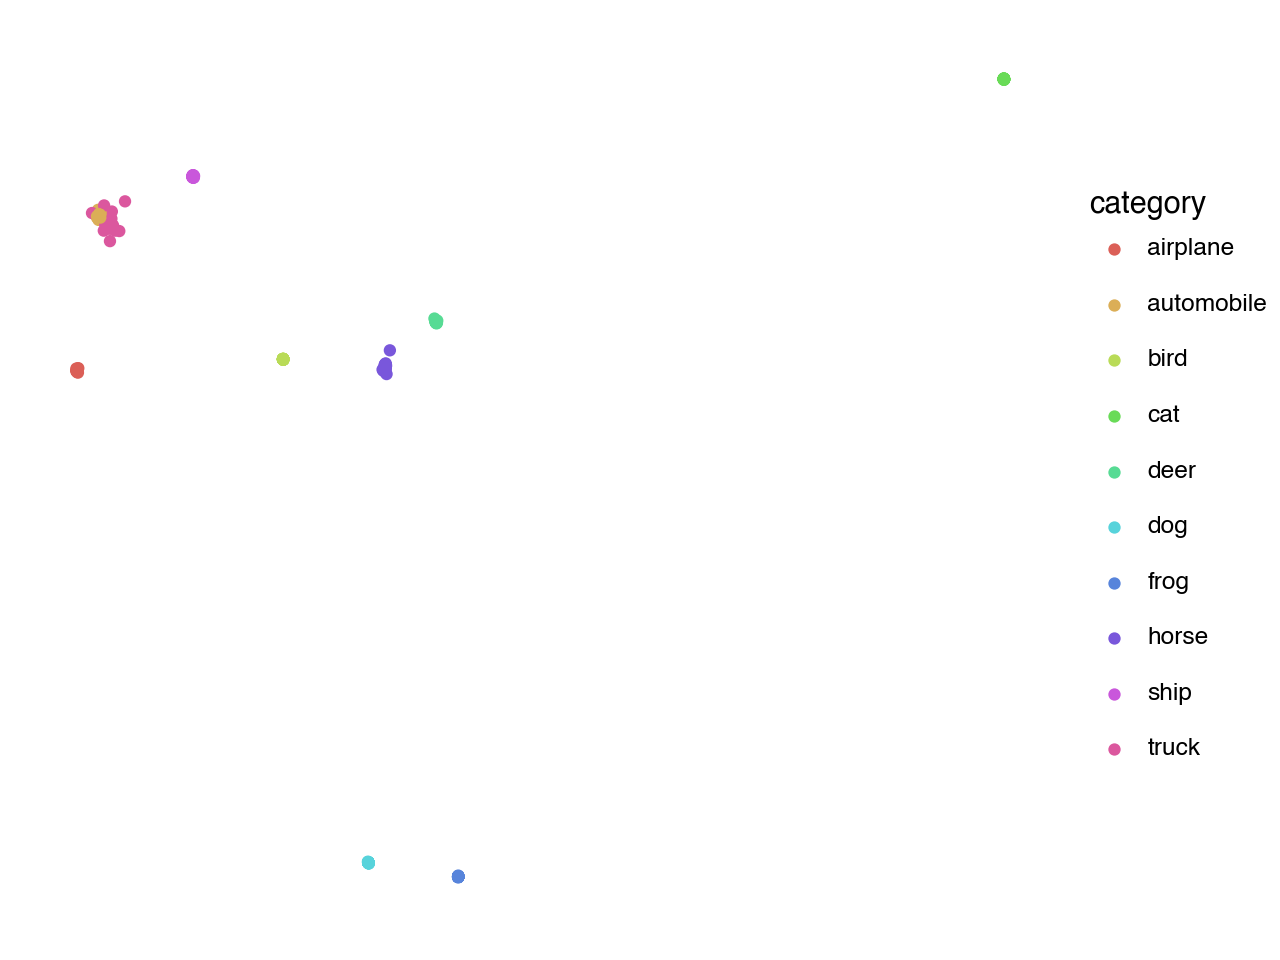

<Figure Size: (640 x 480)>

In [61]:
from plotnine import ggplot, aes, geom_point, labs, theme_void

(ggplot(df, mapping=aes(x="x", y="y", color="category"))+
 geom_point()+
 theme_void())

This looks a bit weird. We're plotting 1,000 points but you can't see most of them. That's because they are on top of each other. The categories are VERY separated at the output layer of the network, which makes sense because the output is the categorization decision!

## Part 5: Latent features

In part 4, we looked at the final output of the VGG16 model: the categorization decision. Unsurprisingly, the values here clustered very strongly.

In this part, we will learn how to extract the activation values from the middle layers of the network and perform LDA on those features.

Keras has a function called `.get_layer()`, which you can call on any Keras model. You can pass in either the `index` of the layer or the `name` of the layer. The `name` is much easier to track, and so this is another reason to specify the `name` parameter when you are building new layers.

Take a look at the `.summary()` of the VGG16 model. The names are listed on the left side. To get the layer right before the output, you could use `vgg16.get_layer('fc2')`.

We can use this `.get_layer()` method to build sub-models. For example, building a new model with `tf.keras.Model()` and setting `outputs` to `vgg16.get_layer(name="fc2").output` will use the `fc2` layer as the output of the new model. The input to any model can be retrieved with `.input`, so setting the `inputs` parameter to `vgg16.input` will build a new model that contains all of the VGG16 layers except the final categorization layer.

You can then use this to get the model's features for our set of images, which we created above.

In [62]:
# create the sub-model
vgg16_rep_model = tf.keras.Model(vgg16_model.input, vgg16_model.get_layer(name="fc2").output)

In [63]:
# generate predictions
vgg16_rep_model_predictions = vgg16_rep_model.predict(x_train)

32/32 [==============================] - 84s 3s/step


In [64]:
vgg16_rep_model_predictions.shape

(1000, 4096)

Once you have these features, follow the same steps that we did above to run LDA and generate the visualization. This should look more like the patterns we saw in the paper.

In [65]:
# run the LDA
rep_lda_x = vgg16_rep_model_predictions
rep_lda_y = y_train[0:1000]

lda.fit(rep_lda_x, rep_lda_y)

rep_two_dimensional_projection = lda.transform(rep_lda_x)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [66]:
# create the data frame with the 2D data
rep_df = pd.DataFrame(rep_two_dimensional_projection, columns=["x", "y"])
rep_lda_y = rep_lda_y.reshape(1000)
rep_df['category'] = [category_list[i] for i in rep_lda_y]

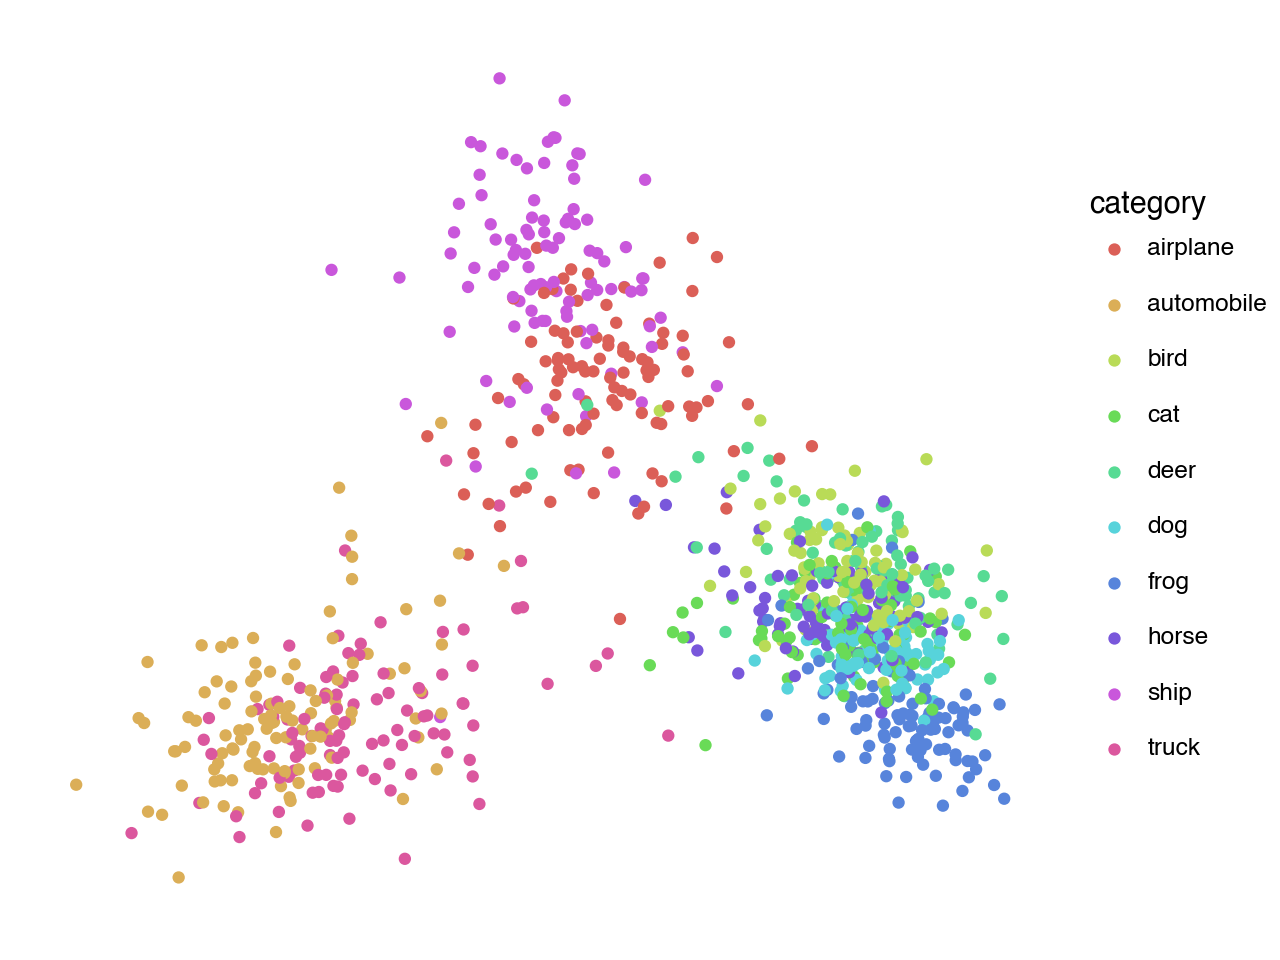

<Figure Size: (640 x 480)>

In [67]:
# plot the result
(ggplot(rep_df, mapping=aes(x="x", y="y", color="category"))+
 geom_point()+
 theme_void())

### Creating a function to run this analysis

Our goal now is to explore how the LDA changes as we move through the network. In other words, we want to know where in the CNN do we start to see features that support the kind of categorization behavior that was described in the paper.

We could copy/paste the code above a bunch of times, changing which layer we are investigating. That would be fine, but let's practice writing a function to make this easier for ourselves.

Create a function using `def lda_features(layer):`, where the `layer` parameter is the name of the layer that you want to extract features from.

The function should go through all the steps we did above:

1. Create a new sub-model with the appropriate layer as output.
2. Get the feature values from the layer.
3. (If the layer is convolutional and the shape has more than one dimension, you will need to reshape it to a flat array)
4. Create an LDA object
5. Run the LDA analysis
6. Plot the results. (Bonus points for figuring out how to add a title to your plot that matches the layer name you are analyzing.

In [68]:
def lda_features(layer):
    submodel = tf.keras.Model(vgg16_model.input, layer)
    submodel_predictions = submodel.predict(x_train)
    submodel_predictions = submodel_predictions.reshape(1000, -1)

    submodel_lda_x = submodel_predictions
    submodel_lda_y = y_train[0:1000].reshape(-1)
    lda.fit(submodel_lda_x, submodel_lda_y)
    submodel_2D_projection = lda.transform(submodel_lda_x)

    submodel_df = pd.DataFrame(submodel_2D_projection, columns=["x", "y"])
    submodel_lda_y = submodel_lda_y.reshape(1000)
    submodel_df['category'] = [category_list[i] for i in submodel_lda_y]

    submodel_plot = (ggplot(submodel_df, mapping=aes(x="x", y="y", color="category"))+
     geom_point()+
     labs(title="LDA Analysis for Submodel with " + layer.name + " Layer as Output.")+
     theme_void())

    return submodel_plot

### Run it!

With your function, run LDA on the various layers of the model. I'd recommend focusing on the MaxPooling layers, but you could explore more than that as well.

#### Exploring LDA of Pooling Layers

In [69]:
# block1_pool_lda = lda_features(vgg16_model.get_layer('block1_pool').output)
# block1_pool_lda

# Takes too long to run (impossibly so)

In [70]:
# block2_pool_lda = lda_features(vgg16_model.get_layer('block2_pool').output)
# block2_pool_lda

# Also takes too long to run (for my taste)

32/32 [==============================] - 58s 2s/step


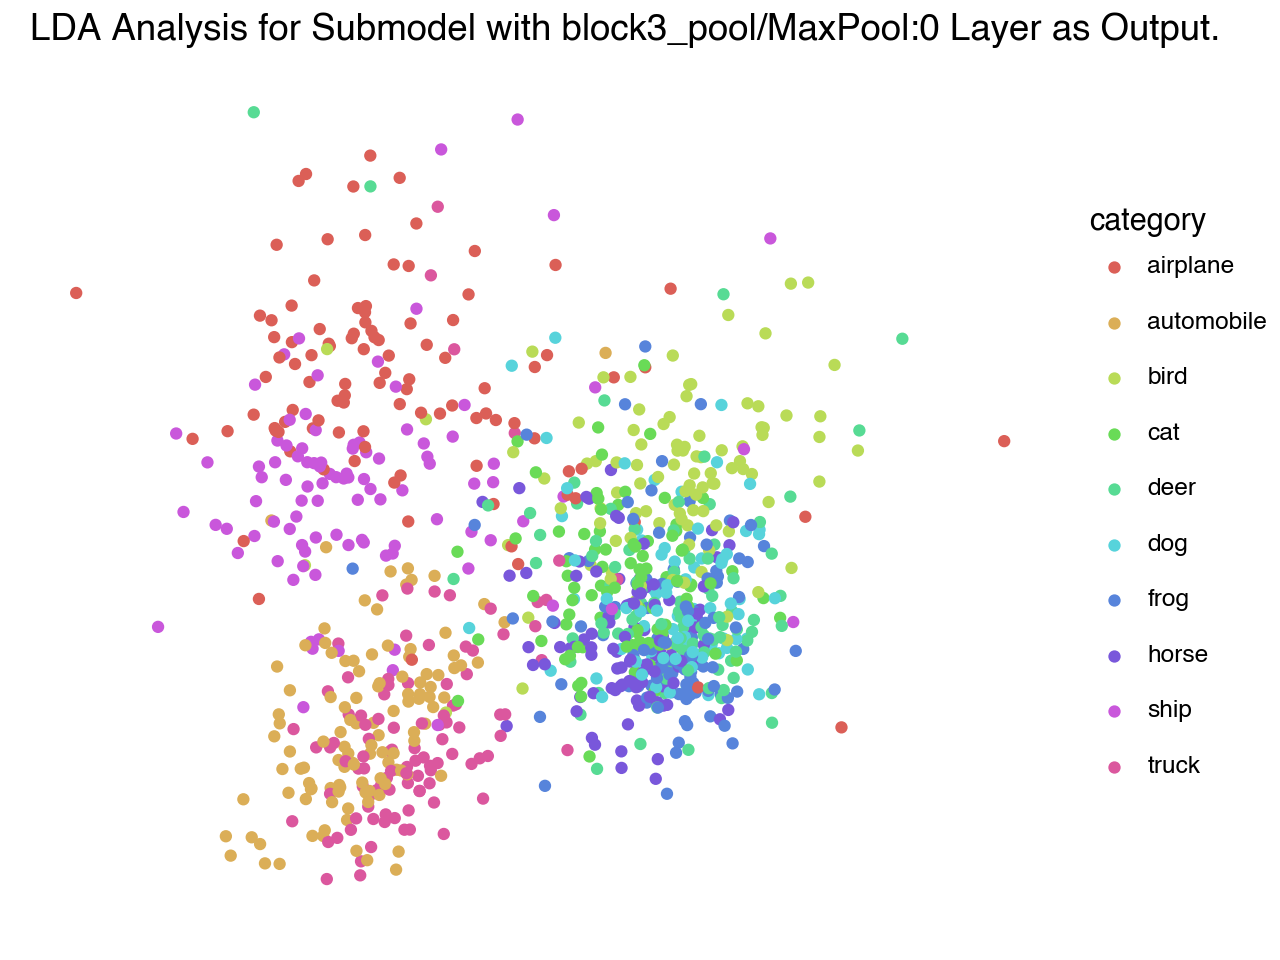

<Figure Size: (640 x 480)>

In [71]:
block3_pool_lda = lda_features(vgg16_model.get_layer('block3_pool').output)
block3_pool_lda

32/32 [==============================] - 73s 2s/step


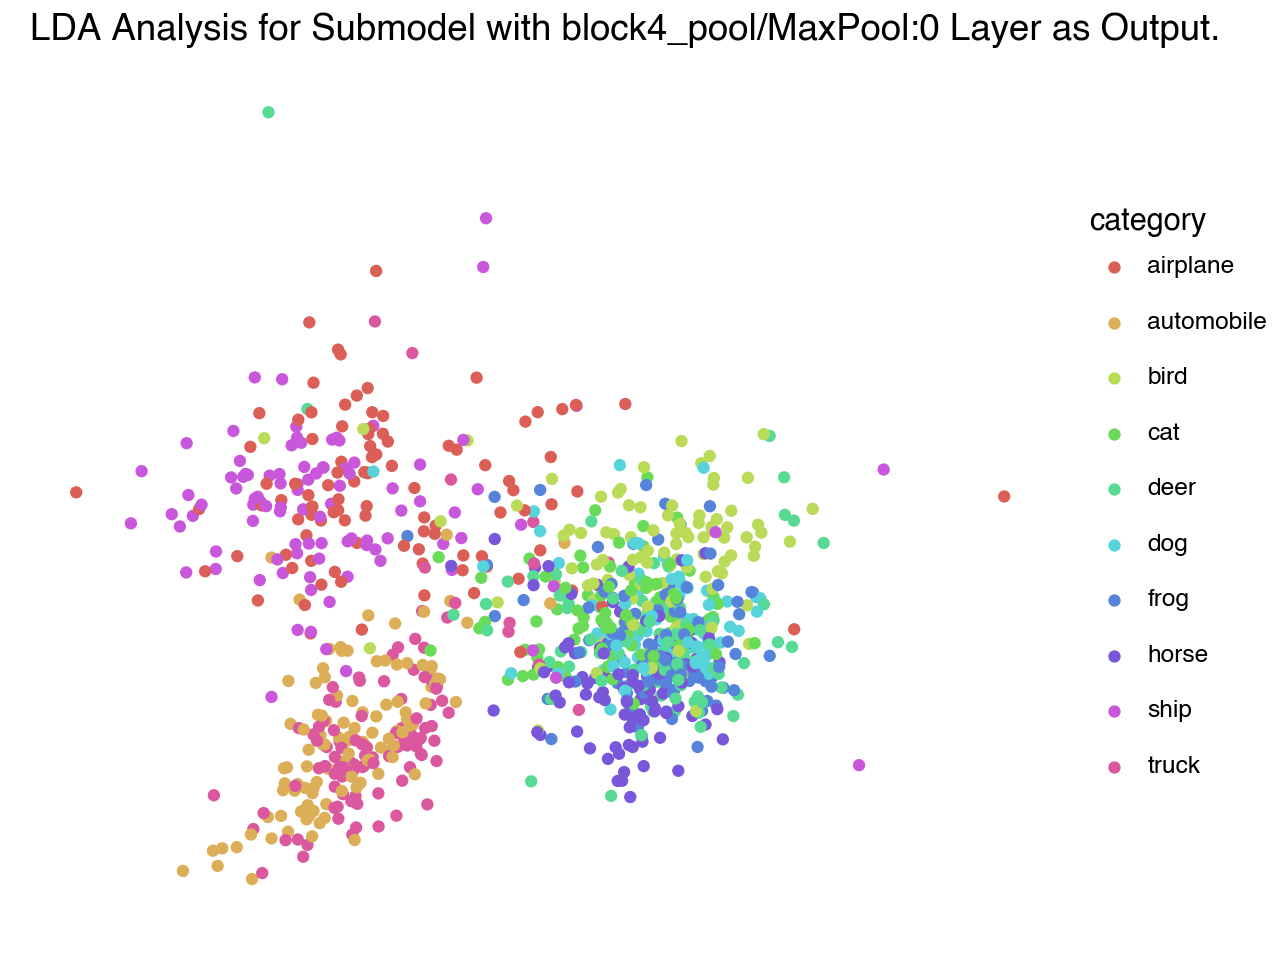

<Figure Size: (640 x 480)>

In [72]:
block4_pool_lda = lda_features(vgg16_model.get_layer('block4_pool').output)
block4_pool_lda

32/32 [==============================] - 80s 3s/step


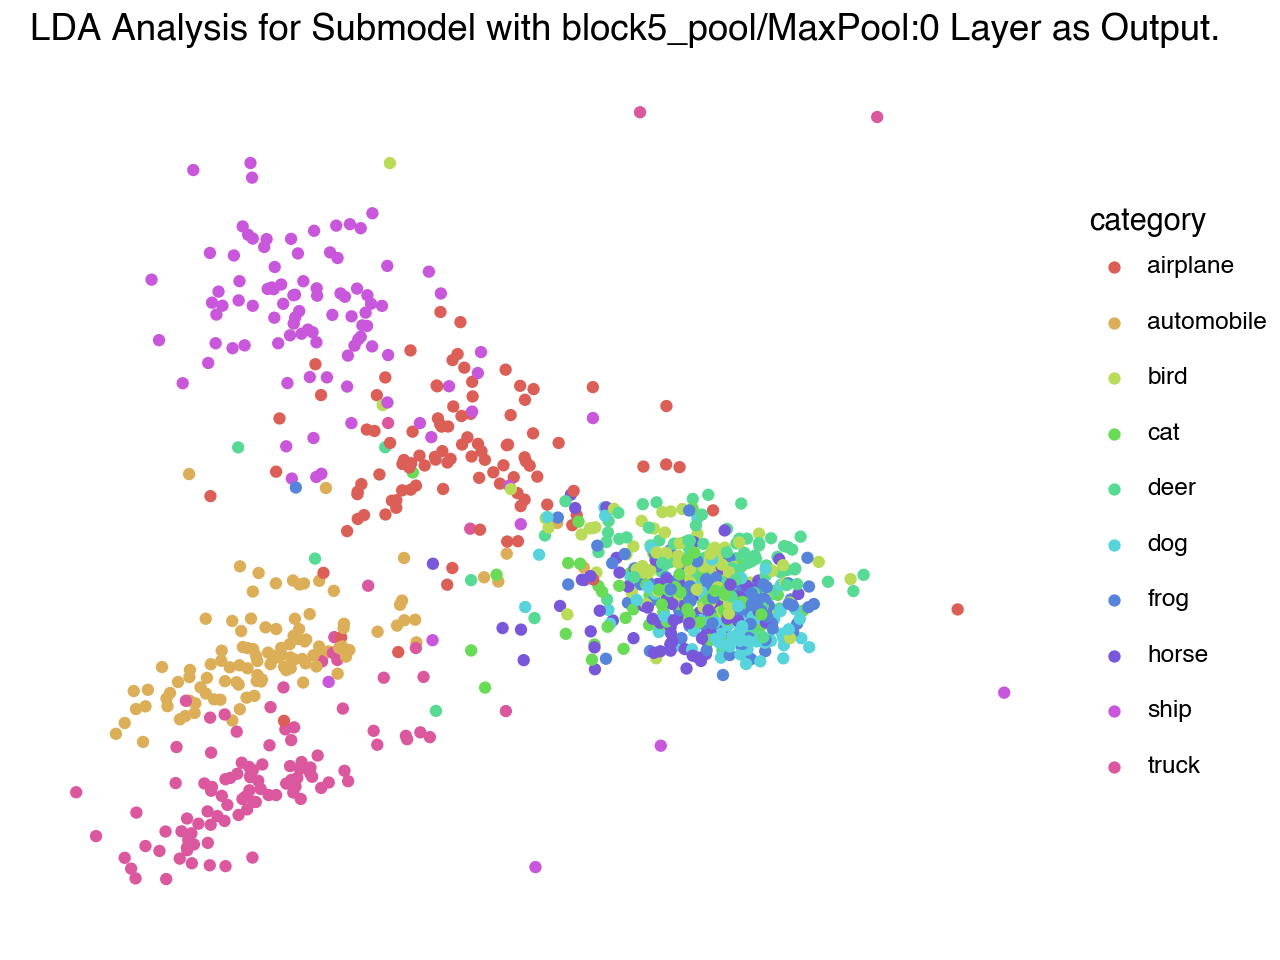

<Figure Size: (640 x 480)>

In [73]:
block5_pool_lda = lda_features(vgg16_model.get_layer('block5_pool').output)
block5_pool_lda

#### Exploring LDA of Convolutional Layers

In [37]:
# block1_conv1_lda = lda_features(vgg16_model.get_layer('block1_conv1').output)
# block1_conv1_lda

# also takes forever

In [38]:
# block1_conv2_lda = lda_features(vgg16_model.get_layer('block1_conv2').output)
# block1_conv2_lda

# kernel restarts

In [1]:
block2_conv1_lda = lda_features(vgg16_model.get_layer('block2_conv1').output)
block2_conv1_lda

NameError: name 'lda_features' is not defined

In [74]:
block2_conv2_lda = lda_features(vgg16_model.get_layer('block2_conv2').output)
block2_conv2_lda

32/32 [==============================] - 32s 976ms/step


KeyboardInterrupt: 

In [ ]:
# block3_conv1_lda = lda_features(vgg16_model.get_layer('block3_conv1').output)
# block3_conv1_lda

In [ ]:
# block3_conv2_lda = lda_features(vgg16_model.get_layer('block3_conv2').output)
# block3_conv2_lda

In [ ]:
# block3_conv3_lda = lda_features(vgg16_model.get_layer('block3_conv3').output)
# block3_conv3_lda

In [ ]:
# block4_conv1_lda = lda_features(vgg16_model.get_layer('block4_conv1').output)
# block4_conv1_lda

In [ ]:
# block4_conv2_lda = lda_features(vgg16_model.get_layer('block4_conv2').output)
# block4_conv2_lda

In [ ]:
# block4_conv3_lda = lda_features(vgg16_model.get_layer('block4_conv3').output)
# block4_conv3_lda

In [ ]:
# block5_conv1_lda = lda_features(vgg16_model.get_layer('block5_conv1').output)
# block5_conv1_lda

In [ ]:
# block5_conv2_lda = lda_features(vgg16_model.get_layer('block5_conv2').output)
# block5_conv2_lda

In [ ]:
# block5_conv3_lda = lda_features(vgg16_model.get_layer('block5_conv3').output)
# block5_conv3_lda

I gave up on trying to visualize these. I assume the deeper the feature maps become with each successive convolutional layer, the more computationally heavy they become.

### Reflect

What was the pattern that you observed with this analysis? What does this tell us about CNN features and how does it relate to the analysis done in the Battleday, Peterson, and Griffiths paper?

**Pattern Observed:**
The observation that the LDA visualization for the second convolutional layer only has a few data points spread across the graph space suggests that at this point, the model has not yet formed cohesive representations of the item within and across categories, such that items are so sparsely and randomly distributed that only a few small clusters can be seen when the window is zoomed out far enough to include all data points. This in turn explains why the LDA visualization of the first convolutional layer cannot even be displayed given our computational resources - the data points are so far apart that the vector space they span is too large to be displayed.

As we can go from the second of the five convolutional layers to the last, the LDA analyses of the model's representations show different clusters corresponding to each concepts more and more clearly. Visually, this is evident form how the LDA visualizations for the third to fifth convolutional layers show many data points close together, and because they are color coded by the category they belong to, we can see large clusters of data points of similar color, suggesting that the model is able to form representations where items of the same category are grouped closely, giving it some form of "knowledge" of these categories. (this may change with a rerun of the whole script, but in my current time of writing-) it's interesting to me that the third and fourth convolutional layers seem to look more similar , where the clusters are closer to each other and have more overlaps than the fifth. I feel like the fifth represents the ideal representational form, where items within a cluster representing a category are very close to each other, but clusters as a whole are more distinct from each other, which I take to mean that the model not only learned the existence of categories, but is able to clearly differentiate them, i.e. "the apparent class separability increases while within-class
variability decreases".

I also tried to visualize the LDA analysis of the pooling layers, and found that the visualizations for those are also too computationally expensive to display. My understanding is each max pooling layer reduces the spatial dimension of the input, while each convolutional layer increases the depth of the feature map, aka creates higher dimension representations of the input.

**How this relates to the paper**:
The paper says:
1. Using large dataset of naturalistic (i.e at varying degrees of ambiguity) high-dimensional images > small dataset of artificial low-dimensional images
2. Models using CNN representations > models that do not
3. Cognitive models that modify CNN representations > pure CNNs > models that do not use convolution
4. At low dimensions, exemplar models > prototype models; but at high dimensions both perform equally well

Our dataset is a subset of the CIFAR10 dataset the paper uses, so our successful results also encourage the use of naturalistic high-dimensional images. [Josh] Since we are training the model with x_train and y_train, i.e. we are giving the model the correct answer to each categorization trial, and there is no specific labelling of a representative image for each category in x_train, we are doing supervised exemplar training here as opposed to unsupervised and/or prototype. Our success in seeing categorical clusters in the final visualizations of the model's representations supports the paper's use of supervised exemplar training on naturalistic stimuli, and confirms that an architecture where we use a cognitive model (exemplar) on top of (modifying) CNN representations, *works*. However, because we didn't train our model on an unsupervised and/or prototype-based dataset as a control, we can neither add to the debate on whether supervised or unsupervised training is better for human categorization, nor whether prototype training or exemplar training is better. It follows that we also cannot agree/disagree with the paper's point that the decision between prototype and exemplar doesn't matter, in addition to the fact that we didn't try running VGG16 on a small dataset of artificial low-dimensional images to compare the performance of an exemplar model using CNN representations in low-dimensional vs high-dimensional categorization tasks.

We *can* say something about how this kind of model compares to non-CNN models though. Based on pure observation and subjective judgment, it looks to me like our trained VGG16 model performed better than the pixel-based, hand-engineered computer vision features (HOG), and unsupervised generative CNN models. Its performance is similar to AlexNet, and definitely not as good as DenseNet from the book, although this is all under the caveat that it was trained with a smaller, though still naturalistic and high-dimensional, dataset. Since ours is a convolutional network under supervised training, our findings match those of the paper's that networks using CNN representations outperform those that do not (Pixel and HOG), and that within CNNs, those with supervised CNN stimulus representations outperform those with unsupervised training (BiGAN).

I think an interesting thing to compare is the number of convolutional layers across these models. AlexNet has 5, VGG16 has 13 convolutional layers, and DenseNet-121 has 117. It seems that these statistics, combined with the observation that the LDA visualizations of the model's representational space gets better as we go from the first convolutional layer to the last, suggests that as number of convolutional layers increase, the better the representations get. However, there is probably an optimal number of convolutional layers stacked in a model before adding more begins to hinder performance, though what the ballpark for this number is is not so clear to me (there are architectures with 1000+ convolutional layers). It also seems that this optimal number is model architecture-dependent, and especially modulated by how many more dimensions each layer adds to the depth of the feature maps. DenseNet, for example, only adds a few dimensions with each convolutional layer, compared to VGG16 that doubles the dimensionality of the feature map with each convolutional layer.

In general, our findings support the paper's assertion that CNN networks trained on large naturalistic image datasets are able to generalize broadly, such that they are more likely to approximate the experience a human might have with categorizing a particular category of natural objects. Categorization models including supervised CNN representations, so far then, are the best-suited to model human categorization of natural images.